In [1]:
import sqlite3
import pandas as pd
from contextlib import closing

In [2]:
'''
with closing(sqlite3.connect("../db/remote-simulations.db")) as connection:
    with closing(connection.cursor()) as cursor:
        rows = cursor.execute("SELECT * from results").fetchall()
        print(rows)
'''
with closing(sqlite3.connect("../db/remote-simulations.db")) as connection:
    sql_query = pd.read_sql_query("SELECT * from results", connection)
    results = pd.DataFrame(sql_query)

results.head()

,execution_time,experiment_id,window_size,max_nodes,nodes_count,max_services,services_count,dataset,metric_name,metric_value,percentage,lower_bound,upper_bound,description
0,0.481855,1,1,5,2,5,2,inmates_enriched_10k,qualitative,0.337593,0.287329,0.2,1.0,column and row filtering with column_frac=0.2
1,0.231139,1,2,5,2,5,2,inmates_enriched_10k,qualitative,0.337593,0.287329,0.2,1.0,column and row filtering with column_frac=0.2
2,0.399061,1,1,5,3,5,2,inmates_enriched_10k,qualitative,0.477892,0.113511,0.2,1.0,column and row filtering with column_frac=0.2
3,0.466509,1,2,5,3,5,2,inmates_enriched_10k,qualitative,0.477892,0.113511,0.2,1.0,column and row filtering with column_frac=0.2
4,0.440229,1,3,5,3,5,2,inmates_enriched_10k,qualitative,0.477892,0.113511,0.2,1.0,column and row filtering with column_frac=0.2


In [3]:
import operator
import functools

tested_datasets = results['dataset'].unique()
NODES_COUNT = 5
SERVICES_COUNT = 5
METRIC_NAME = 'qualitative'
LOWER_BOUND = 0.2
UPPER_BOUND = 1.0

results_filters = [
    lambda df: df['services_count'] == SERVICES_COUNT,
    lambda df: df['nodes_count'] == NODES_COUNT,
    lambda df: df['metric_name'] == METRIC_NAME,
    lambda df: df['lower_bound'] == LOWER_BOUND,
    lambda df: df['upper_bound'] == UPPER_BOUND,
    lambda df: df['description'] == 'column and row filtering (assigning none to filtered) with column_frac=0.8'
]

def apply_filters_to_dataset(df, filters):
    compound_condition = functools.reduce(operator.and_, map(lambda filter: filter(df), filters))
    return df[compound_condition]

results_per_dataset = {}
for dataset in tested_datasets:
    dataset_results = apply_filters_to_dataset(results, results_filters + [lambda df: df['dataset'] == dataset]) \
        .groupby(['window_size'])[['metric_value']].mean() \
        .sort_values(by=['window_size', 'metric_value'])
        #.sort_values(by=['experiment_id', 'window_size', 'description'])

    display(dataset_results)
    results_per_dataset[dataset] = dataset_results

,metric_value
window_size,
1,0.643771
2,0.568494
3,0.555274
4,0.546739
5,0.546739


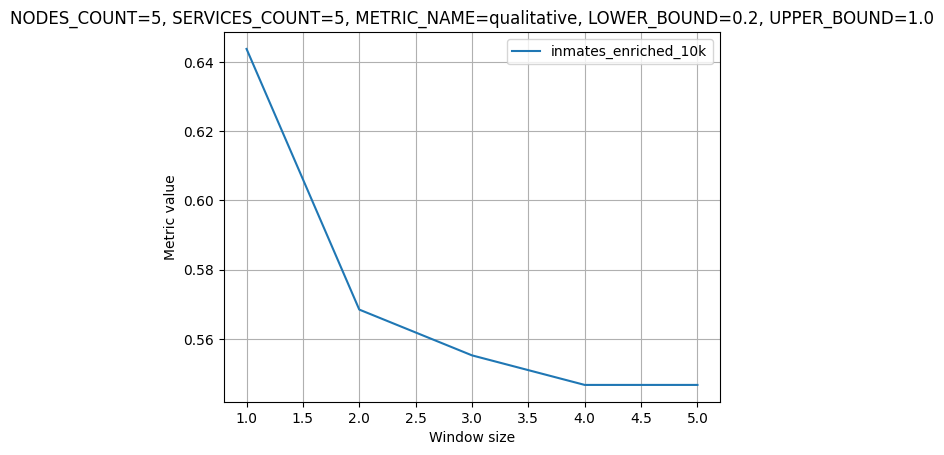

In [4]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
# plt.figure(figsize=(10, 6))

for dataset, dresults in results_per_dataset.items():
    ax.plot(dresults.index, dresults['metric_value'], label=dataset)

ax.set_title(f'NODES_COUNT={NODES_COUNT}, SERVICES_COUNT={SERVICES_COUNT}, METRIC_NAME={METRIC_NAME}, LOWER_BOUND={LOWER_BOUND}, UPPER_BOUND={UPPER_BOUND}')
ax.set_xlabel('Window size')
ax.set_ylabel('Metric value')
ax.grid(True)
ax.legend()

plt.show()
    